## **EXERCÍCIO 09 - Transfer Learning**

## **CESAR SCHOOL**
* Pós-graduação em Engenharia e Análise de Dados - 2023.2
* **Disciplina: Tópicos Complementares**
* Professor: **Silvan Ferreira**
* Aluno: **Allan Bispo** - apsb@cesar.school

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.models import MobileNet_V2_Weights, VGG16_Weights, ResNet18_Weights
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
def train_model(model, trainloader, valloader, criterion, optimizer, device=device, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_losses'], label='Train')
    ax1.plot(history['val_losses'], label='Validation')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history['train_accuracies'], label='Train')
    ax2.plot(history['val_accuracies'], label='Validation')
    ax2.set_title('Accuracy')
    ax2.legend()

    plt.show()


def test_model(model, testloader, device=device):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')

In [ ]:
# Baixa e extrai o dataset
!curl -L -o data/animais.zip "https://drive.google.com/uc?export=download&id=16Lll0Slg1unWxAb26AzZqI9sPdB_fYpV"
!unzip data/animais.zip -d data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 11.6M  100 11.6M    0     0  1616k      0  0:00:07  0:00:07 --:--:-- 2407k
Archive:  data/animais.zip
   creating: data/animais/val/tatu/
  inflating: data/animais/val/tatu/10242.jpg  
  inflating: data/animais/val/tatu/10209.jpg  
  inflating: data/animais/val/tatu/10251.jpg  
  inflating: data/animais/val/tatu/10202.jpg  
  inflating: data/animais/val/tatu/10243.jpg  
  inflating: data/animais/val/tatu/10215.jpg  
  inflating: data/animais/val/tatu/10254.jpg  
  inflating: data/animais/val/tatu/10241.jpg  
  inflating: data/animais/val/tatu/10238.jpg  
  inflating: data/animais/val/tatu/10228.jpg  
  inflating: data/animais/val/tatu/10203.jpg  
  inflating: data/animais/val/tatu/10236.jpg  
  inflating: data/animais/val/tatu/10220.jpg  
  inflatin

In [ ]:
# Carregando os datasets
transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_no_aug = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# data_dir = 'data/hymenoptera_data'
data_dir = "data/animais"

train_set = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_aug)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

In [ ]:
model = models.resnet18(weights="IMAGENET1K_V1")

In [ ]:
# Mostras os módulos do modelo

for name, module in model.named_modules():
    print(f"Module Name: {name}")
    print(module)
    print("="*50)

Module Name: 
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(in

In [ ]:
# Congelar todas as camadas
for param in model.parameters():
    param.requires_grad = False

In [ ]:
# Substituir a última camada
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Treinando a CNN
history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

100%|██████████| 13/13 [00:38<00:00,  2.94s/it]
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1, Train Loss: 0.686, Train Accuracy: 61.00%
Epoch 1, Val Loss: 0.402, Val Accuracy: 88.52%


100%|██████████| 13/13 [00:37<00:00,  2.92s/it]


Epoch 2, Train Loss: 0.438, Train Accuracy: 82.00%
Epoch 2, Val Loss: 0.259, Val Accuracy: 92.62%


100%|██████████| 13/13 [00:38<00:00,  2.94s/it]


Epoch 3, Train Loss: 0.342, Train Accuracy: 86.25%
Epoch 3, Val Loss: 0.178, Val Accuracy: 94.26%


100%|██████████| 13/13 [00:38<00:00,  2.95s/it]


Epoch 4, Train Loss: 0.294, Train Accuracy: 89.00%
Epoch 4, Val Loss: 0.214, Val Accuracy: 93.44%


100%|██████████| 13/13 [00:37<00:00,  2.92s/it]


Epoch 5, Train Loss: 0.237, Train Accuracy: 91.25%
Epoch 5, Val Loss: 0.134, Val Accuracy: 95.90%
Treinamento concluído


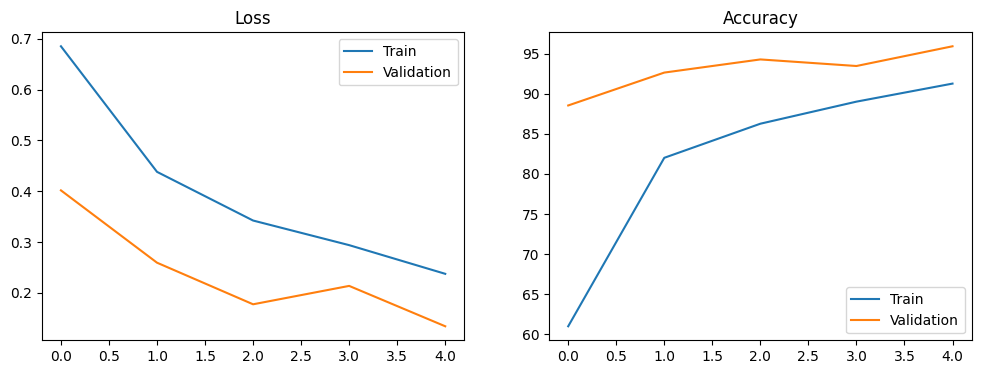

In [ ]:
plot_history(history)

In [ ]:
test_model(model, val_loader)

Acurácia da rede na base de teste: 95.90%


In [ ]:
def plot_and_predict(model, image, class_names, device=device):
    model.eval()
    image = image.to(device)
    outputs = model(image.unsqueeze(0))
    _, predicted = torch.max(outputs.data, 1)
    probs = F.softmax(outputs, dim=1)[0] * 100
    prob = probs[predicted].item()

    # image between 0 and 1
    image = torch.clamp(image * 0.225 + 0.45, 0, 1)
    title = f'Classe: {class_names[predicted]} ({prob:.2f}%)'
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis('off')
    plt.show()

In [ ]:
images, labels = next(iter(val_loader))

for image, label in zip(images, labels):
    plot_and_predict(model, image, val_set.classes)

Output hidden; open in https://colab.research.google.com to view.

## Exercícios

### Exercício 1
Treine novamente o modelo, mas sem data augmentation. Compare as curvas de treinamento de ambos os casos e comente.

In [ ]:
# Carregando os dados de treino sem 'augmentation'

train_set_sem_aug = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_no_aug)
train_loader_sem_aug = DataLoader(train_set_sem_aug, batch_size=32, shuffle=True)

In [ ]:
# Carregando o model, criterion e optimizer novamente

model = models.resnet18(weights="IMAGENET1K_V1")

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Treinando o modelo sem 'augmentation'

history_sem_aug = train_model(model, train_loader_sem_aug, val_loader, criterion, optimizer, device, num_epochs=5)

100%|██████████| 13/13 [00:38<00:00,  2.93s/it]


Epoch 1, Train Loss: 0.629, Train Accuracy: 66.00%
Epoch 1, Val Loss: 0.407, Val Accuracy: 86.07%


100%|██████████| 13/13 [00:38<00:00,  2.92s/it]


Epoch 2, Train Loss: 0.329, Train Accuracy: 89.25%
Epoch 2, Val Loss: 0.228, Val Accuracy: 92.62%


100%|██████████| 13/13 [00:38<00:00,  2.94s/it]


Epoch 3, Train Loss: 0.261, Train Accuracy: 92.00%
Epoch 3, Val Loss: 0.195, Val Accuracy: 95.08%


100%|██████████| 13/13 [00:38<00:00,  2.93s/it]


Epoch 4, Train Loss: 0.185, Train Accuracy: 95.25%
Epoch 4, Val Loss: 0.167, Val Accuracy: 95.90%


100%|██████████| 13/13 [00:38<00:00,  2.93s/it]


Epoch 5, Train Loss: 0.172, Train Accuracy: 95.25%
Epoch 5, Val Loss: 0.158, Val Accuracy: 95.90%
Treinamento concluído


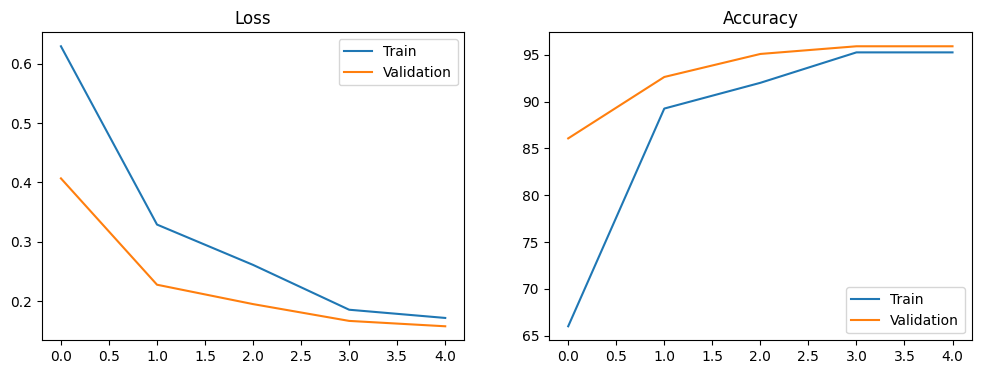

In [ ]:
# Curvas de Loss e Accuracy sem 'augmentation'

plot_history(history_sem_aug)

#### RESPOSTA EXERCÍRCIO 1:

* Ao final das épocas de treino pode-se comparar que, **SEM data augmentation** (sem expansão do dataset de treino), os resultados de perda e acurácia foram melhores.
* Todavia, nesse caso, isso não é um indicativo de um modelo melhor, muito pelo contrário, é um **indicativo de possível overfitting**.
* Isso pois o **modelo está menos generalista**, aprendeu com poucos dados, estando assim condicionado às poucas features apresentadas no dataset de treino.

  * **COM augmentation**: Train Loss: 0.293, Train Accuracy: 88.50%

  * **SEM augmentation**: Train Loss: 0.172, Train Accuracy: 95.25%

### Exercício 2
Descongele mais das últimas camadas (à sua escolha), por exemplo `model.layer4[1]`, e treine novamente o modelo.

In [ ]:
# Substituindo as camadas layer4.1 e fc

# Descongelar a layer4[1]
for param in model.layer4[1].parameters():
    param.requires_grad = True

model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

In [ ]:
# Rodando a cross entropy e o otimizador agora com as 2 camadas substituídas

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Treinando a CNN novamente

history_l4 = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

100%|██████████| 13/13 [00:48<00:00,  3.71s/it]
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1, Train Loss: 0.672, Train Accuracy: 59.50%
Epoch 1, Val Loss: 0.406, Val Accuracy: 89.34%


100%|██████████| 13/13 [00:43<00:00,  3.31s/it]


Epoch 2, Train Loss: 0.356, Train Accuracy: 88.00%
Epoch 2, Val Loss: 0.182, Val Accuracy: 97.54%


100%|██████████| 13/13 [00:44<00:00,  3.43s/it]


Epoch 3, Train Loss: 0.311, Train Accuracy: 86.00%
Epoch 3, Val Loss: 0.126, Val Accuracy: 97.54%


100%|██████████| 13/13 [00:43<00:00,  3.31s/it]


Epoch 4, Train Loss: 0.258, Train Accuracy: 90.00%
Epoch 4, Val Loss: 0.166, Val Accuracy: 92.62%


100%|██████████| 13/13 [00:42<00:00,  3.29s/it]


Epoch 5, Train Loss: 0.210, Train Accuracy: 92.75%
Epoch 5, Val Loss: 0.096, Val Accuracy: 97.54%
Treinamento concluído


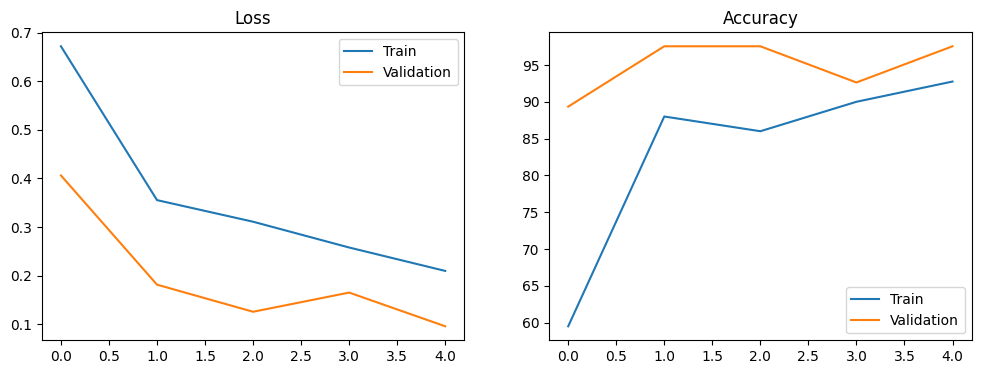

In [ ]:
# Visualizando as perdas e acurácia com as novas camadas

plot_history(history_l4)

In [ ]:
# Testando o modelo na nova configuração de camadas

test_model(model, val_loader)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Acurácia da rede na base de teste: 97.54%


----------------------------------------------------------------------------
#####Descongelando também a layer4[0]

In [ ]:
# Substituindo as camadas layer4.0, layer4.1 e fc

# Descongelar a layer4[0]
for param in model.layer4[0].parameters():
    param.requires_grad = True

# Descongelar a layer4[1]
for param in model.layer4[1].parameters():
    param.requires_grad = True

model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

In [ ]:
# Rodando a cross entropy e o otimizador agora com as 3 camadas substituídas

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Treinando a CNN novamente, agora com as 3 camadas substituídas

history_l4_0_1 = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

100%|██████████| 13/13 [00:51<00:00,  3.96s/it]
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1, Train Loss: 0.640, Train Accuracy: 62.00%
Epoch 1, Val Loss: 0.315, Val Accuracy: 91.80%


100%|██████████| 13/13 [00:49<00:00,  3.81s/it]


Epoch 2, Train Loss: 0.351, Train Accuracy: 86.25%
Epoch 2, Val Loss: 0.245, Val Accuracy: 90.98%


100%|██████████| 13/13 [00:49<00:00,  3.78s/it]


Epoch 3, Train Loss: 0.259, Train Accuracy: 90.75%
Epoch 3, Val Loss: 0.105, Val Accuracy: 95.90%


100%|██████████| 13/13 [00:49<00:00,  3.78s/it]


Epoch 4, Train Loss: 0.205, Train Accuracy: 93.50%
Epoch 4, Val Loss: 0.125, Val Accuracy: 95.08%


100%|██████████| 13/13 [00:49<00:00,  3.82s/it]


Epoch 5, Train Loss: 0.242, Train Accuracy: 90.00%
Epoch 5, Val Loss: 0.080, Val Accuracy: 99.18%
Treinamento concluído


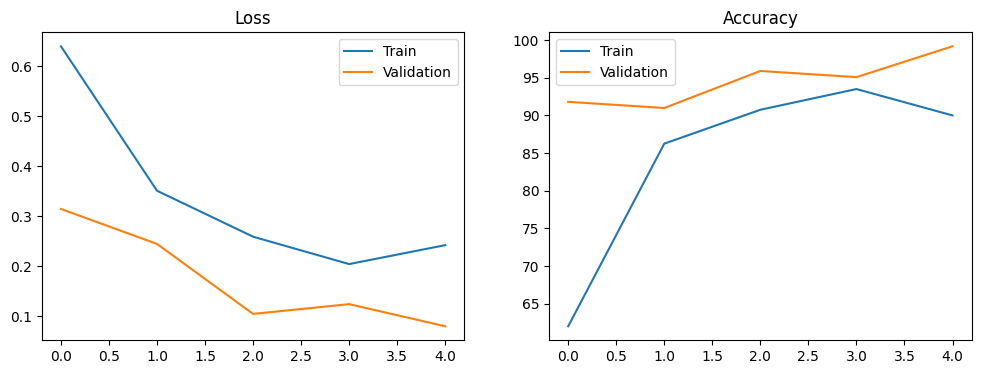

In [ ]:
# Visualizando as perdas e acurácia com as novas camadas

plot_history(history_l4_0_1)

In [ ]:
# Testando o modelo na nova configuração de camadas

test_model(model, val_loader)

Acurácia da rede na base de teste: 99.18%


#### RESPOSTA EXERCÍRCIO 2:

* À medida que as **camadas** finais do modelo vão sendo **descongeladas**, juntamente com a fully connected, o **modelo torna-se mais calibrado**, resultando em melhores acurácia, o que é bem característico do **fine tunning**.
* Abaixo pode-se comparar a evolução do processo de fine tunning:
  * **Descongelamento apenas fc: Acurácia** da rede na base de teste: **95.90%**
  * **Descongelamento layer4[1] + fc: Acurácia** da rede na base de teste: **97.54%**
  * **Descongelamento layer4[0,1] + fc: Acurácia** da rede na base de teste: **99.18%**

### Exercício 3
Escolha outro modelo pré-treinado dos que foram vistos na aula e substitua no modelo. Lembre-se de alterar a última camada de classificação.

-----------------------------------------
#####Testando com o modelo **AlexNet**

In [ ]:
#Testando com o modelo AlexNet

model = models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 150MB/s]


In [ ]:
# Congelar todas as camadas agora com o modelo AlexNet

for param in model.parameters():
    param.requires_grad = False

In [ ]:
# Substituir a última camada agora com o modelo AlexNet

num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 2)
model = model.to(device)

In [ ]:
# Rodando a cross entropy e o otimizador agora com o modelo AlexNet

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Treinando a CNN agora com o modelo AlexNet

history_alexnet = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

100%|██████████| 13/13 [00:14<00:00,  1.09s/it]


Epoch 1, Train Loss: 0.521, Train Accuracy: 70.00%


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1, Val Loss: 0.150, Val Accuracy: 91.80%


100%|██████████| 13/13 [00:13<00:00,  1.04s/it]


Epoch 2, Train Loss: 0.228, Train Accuracy: 90.50%
Epoch 2, Val Loss: 0.147, Val Accuracy: 93.44%


100%|██████████| 13/13 [00:13<00:00,  1.02s/it]


Epoch 3, Train Loss: 0.283, Train Accuracy: 87.00%
Epoch 3, Val Loss: 0.124, Val Accuracy: 94.26%


100%|██████████| 13/13 [00:13<00:00,  1.02s/it]


Epoch 4, Train Loss: 0.294, Train Accuracy: 87.00%
Epoch 4, Val Loss: 0.162, Val Accuracy: 91.80%


100%|██████████| 13/13 [00:13<00:00,  1.02s/it]


Epoch 5, Train Loss: 0.215, Train Accuracy: 90.25%
Epoch 5, Val Loss: 0.132, Val Accuracy: 94.26%
Treinamento concluído


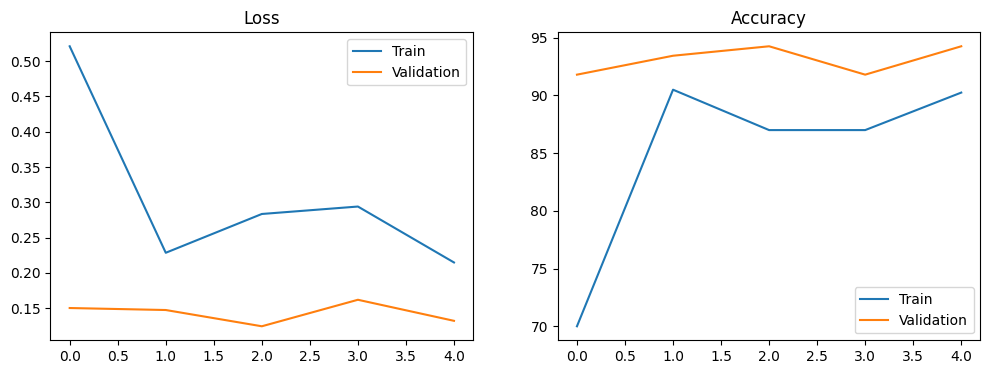

In [ ]:
# Visualizando as perdas e acurácia agora com o modelo AlexNet

plot_history(history_alexnet)

In [ ]:
# Testando o modelo AlexNet

test_model(model, val_loader)

Acurácia da rede na base de teste: 94.26%


-----------------------------------------
#####Testando com o modelo **VGG16**

In [ ]:
# Alterando para VGG16

model = models.vgg16(weights="IMAGENET1K_V1")

In [ ]:
# Congelar todas as camadas agora com o modelo VGG16
for param in model.parameters():
    param.requires_grad = False

In [ ]:
# Substituir a última camada agora com o modelo VGG16
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 2)
model = model.to(device)

In [ ]:
# Rodando a cross entropy e o otimizador agora com o modelo VGG16

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Treinando a CNN agora com o modelo VGG16

history_vgg16 = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

100%|██████████| 13/13 [04:44<00:00, 21.92s/it]


Epoch 1, Train Loss: 0.437, Train Accuracy: 79.75%
Epoch 1, Val Loss: 0.155, Val Accuracy: 94.26%


100%|██████████| 13/13 [04:03<00:00, 18.72s/it]


Epoch 2, Train Loss: 0.252, Train Accuracy: 88.50%
Epoch 2, Val Loss: 0.105, Val Accuracy: 95.08%


100%|██████████| 13/13 [04:02<00:00, 18.69s/it]


Epoch 3, Train Loss: 0.197, Train Accuracy: 91.75%
Epoch 3, Val Loss: 0.131, Val Accuracy: 95.08%


100%|██████████| 13/13 [04:03<00:00, 18.72s/it]


Epoch 4, Train Loss: 0.189, Train Accuracy: 91.25%
Epoch 4, Val Loss: 0.099, Val Accuracy: 95.90%


100%|██████████| 13/13 [04:01<00:00, 18.60s/it]


Epoch 5, Train Loss: 0.197, Train Accuracy: 92.75%
Epoch 5, Val Loss: 0.093, Val Accuracy: 96.72%
Treinamento concluído


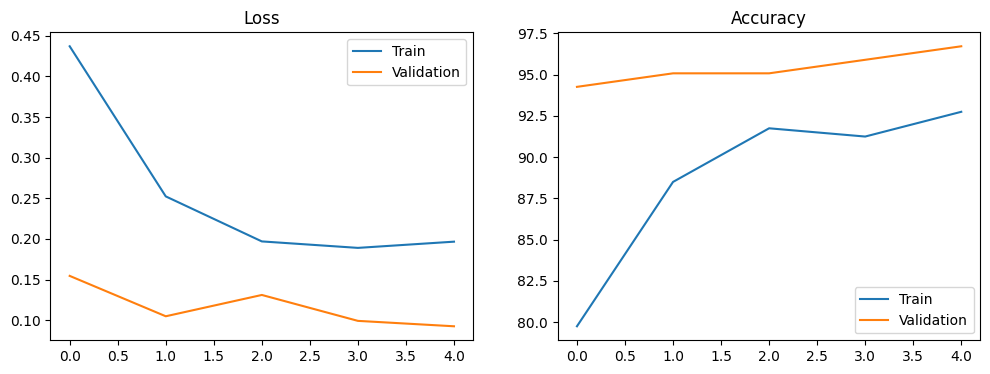

In [ ]:
# Visualizando as perdas e acurácia agora com o modelo VGG16

plot_history(history_vgg16)

In [ ]:
# Testando o modelo VGG16

test_model(model, val_loader)

Acurácia da rede na base de teste: 96.72%


#### RESPOSTA EXERCÍRCIO 3:

* Apesar do **modelo VGG16** apresentar uma melhor performance, o **tempo** gasto no processamento, em especial com device cpu, foi **muito grande para um acréscimo de acurácia de menos de 1pp somente**. Para um dataset simples não se justificaria o uso do VGG16.
* O **modelo AlexNet** foi o **mais rápido** de todos, mas devido a sua arquitetura mais simples, **não conseguiu uma acurácia tão boa**.
* Dos três modelos testados aqui, o **melhor custo-benefício foi o do ResNet18**. Vimos que esse modelo, quando passa por um processo de fine tuning, pode atingir +99% de acurácia sem compromenter tempo ou HW.
* Abaixo pode-se comparar a evolução do processo de fine tunning:
  * **Modelo Resnet18: Acurácia** da rede na base de teste: **95.90%**
  * **Modelo AlexNet: Acurácia** da rede na base de teste: **94.26%**
  * **Modelo VGG16: Acurácia** da rede na base de teste: **96.72%**